# Bayesian Experimental Design for model selection

Script used for Dynamic optimisation where and eight step experiment is being design by optimising sub-divisions of two steps at a time. 

   ............................................................................................................................................................................................................................................

### Import Required libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from numba import jit
import gaussianprocess as gp
from fitderiv import fitderiv
import genutils as gu
import datetime
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import math


### Model 1 Functions (ODEs, Steady State and Event based representation)
* Lugagne et. al. Model

In [2]:
@jit
def model1(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    
    if u_IPTG > y[0]:
        dInd_dt[0]=k_in_IPTG*(u_IPTG-y[0])
    else:
        dInd_dt[0]=k_out_IPTG*(u_IPTG-y[0])
    
    if u_aTc > y[2]:
        dInd_dt[1]=k_in_aTc*(u_aTc-y[1])
    else:
        dInd_dt[1]=k_out_aTc*(u_aTc-y[1])
    
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState1(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode1(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState1(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model1,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 2 Functions (ODEs, Steady State and Event based representation)
* Intermediate Model (Single rate, no degradation)

In [3]:
@jit
def model2(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0]);
    dInd_dt[1] = k_aTc*(u_aTc-y[1]);
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState2(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode2(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState2(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model2,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 3 Functions (ODEs, Steady State and Event based representation)
* Lucia's Model

In [4]:
@jit
def model3(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0])-0.0165*y[0];
    dInd_dt[1] = k_aTc*(u_aTc-y[1])-0.0165*y[1];
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState3(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(4)
    alpha[0] = (k_IPTG*u_IPTG)/(k_IPTG+0.0165)
    alpha[1] = (k_aTc*u_aTc)/(k_aTc+0.0165)
    alpha[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(alpha[1]/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(alpha[0]/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode3(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    
    y_al = SteadyState3(p,ivss) # Calculation of initial guesses for steady state
    
    ssv = odeint(model3,y_al,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]
        
        
        
    
    return(final)

### Functions to simulate the 3 models for all parameter draws

In [5]:
def solveALL (ts, pD, sp, inputs, ivss, pre, model):
    
    AllSol = np.empty((len(ts),len(pD[:,1])*2))
    AllSolTest = np.empty(((round(len(ts)/5)+1),len(pD[:,1])*2))
    for drawInd in range(0,len(pD[:,1])):
        
        p = pD[drawInd,:]
        if model == 'M1':
            temp = solve_coupled_ode1(ts, p, sp, inputs, ivss, pre)
        elif model == 'M2':
            temp = solve_coupled_ode2(ts, p, sp, inputs, ivss, pre)
        elif model == 'M3':
            temp = solve_coupled_ode3(ts, p, sp, inputs, ivss, pre)
        else:
            print('Please, select a correct model as M1, M2 or M3 for the desired one')

        AllSolTest[:,drawInd] = temp[:,2][::5]
        AllSolTest[:,drawInd+(len(pD[:,1]))] = temp[:,3][::5]

    return(AllSolTest)
    

### Example:

In [10]:
ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
inputs = np.empty(18) # What needs to be optimised    --> example: [1e-7,100,1,1e-7]*4+[1e-7,100]
evnT = [int(i) for i in list(np.linspace(0,(24*60),10))]
t = np.linspace(0,(24*60),(24*60)+1)
pM3 = np.asarray(pd.read_csv("ParametersCSV/draws_ALL_Model3.stan.csv"))

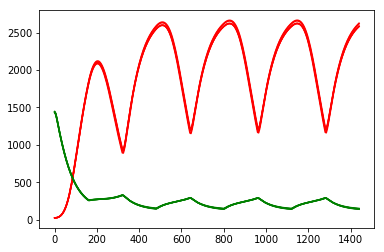

In [15]:
p = pM3[0:5,:]
test = solveALL(t,p,evnT,[1e-7,100,1,1e-7]*4+[1e-7,100],ivss,pre, 'M3')
plt.figure()
plt.plot(t[::5], test[:,0:5], 'r')
plt.plot(t[::5], test[:,5:10], 'g')
plt.show()

### Bhattacharyya distance function:

In [6]:

def BhattacharyyaDist (mu1, mu2, sd1, sd2):
    E = (sd1+sd2)/2
    Em1 = np.linalg.inv(E)
    dE = abs(np.linalg.det(E))

    t1 = np.matrix.transpose((np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))))
    t2 = np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))
    
    ft = (1/8)*t1*Em1*t2
    st = dE/np.sqrt(abs(np.linalg.det(sd1))*abs(np.linalg.det(sd2)))
    
    bhd = ft+0.5*np.log(st)
    
    return(float(bhd))



In [21]:
# Extract time points from flat regions
def textract(mu, cov):

    ft = np.random.multivariate_normal(mu, cov)
    ft2 = np.ndarray.tolist(ft[0:len(ft)-1])
    ft2.insert(0,0)
    ft2 = np.asarray(ft2)
    
    sub = abs(ft[::4]-ft2[::4])
    inde0 = []
    for i in range(0,len(sub)):
        if sub[i] < 1.5:
            inde0.append(i)

    nwar = []
    u = 0
    for j in range(0,len(inde0)-4, 4):
        if sorted(inde0[j:j+4]) == list(range(min(inde0[j:j+4]), max(inde0[j:j+4])+1)):
            l = inde0[j:j+4]
            nw = inde0[j:j+4][::2]
            for k in nw:
                l.remove(k)
            nwar.append(l)#[u] = l
            u += 1
    return(nwar) 

### Definition of the utility functions:

Utility Function for step 1 and 2:

In [72]:

def utility1 (IPTG1, IPTG2,
             aTc1, aTc2):
    
    # Definition of inputs for the ODEs
    
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7]
    
    # Initial values for steady state and inputs
   
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(360),3))]
    t =  np.linspace(0,(360),(360)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
    solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
    solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(360),round(360/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
    muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
    muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::4])
    tref = list(tgp[::4])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::4])
    tref = list(tgp[::4])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::4])
    tref = list(tgp[::4])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::4])
    tref = list(tgp[::4])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Check for too flat reagions that give numerical instability
    if bdR == float("inf") or bdG == float("inf"):
        nwar = []
        nwar1 = textract(gR3.mnp, gR3.covp)
        nwar2 = textract(gR2.mnp, gR2.covp)

        if len(np.asarray(nwar1).reshape(-1,1)) <= len(np.asarray(nwar2).reshape(-1,1)):
            nwar = nwar1
        else:
            nwar = nwar2

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::4])
        tref = list(tgp[::4])


        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        # muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
        # tref = list(tgp[::10])

        g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R3.predict(tref)

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::4])
        tref = list(tgp[::4])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1




        g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R2.predict(tref)

        print(nwar)

        nwar = []
        nwar1 = textract(gG3.mnp, gG3.covp)
        nwar2 = textract(gG2.mnp, gG2.covp)

        if len(np.asarray(nwar1).reshape(-1,1)) <= len(np.asarray(nwar2).reshape(-1,1)):
            nwar = nwar1
        else:
            nwar = nwar2

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::4])
        tref = list(tgp[::4])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2G3.predict(tref)


        muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::4])
        tref = list(tgp[::4])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2G2.predict(tref)
        
        bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
        bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR*bdG)

    return(u_B)

Utility Function for step 3 and 4:

In [79]:

def utility2 (IPTG1, IPTG2,
             aTc1, aTc2):
    
    # Definition of inputs for the ODEs
        
    
    inputs = [round(0.777,2)+1e-7, int(20.01)+1e-7, round(0.755,2)+1e-7, int(22.61)+1e-7,
              round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7]
    
    # Initial values for steady state and inputs
   
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(720),5))]
    t =  np.linspace(0,(720),(720)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
    solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
    solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(360),round(360/5)+1)
    
    muR3 = RFP_M2[int(360/5):int(720/5)+1].mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2[int(360/5):int(720/5)+1].std(axis = 1)
    muG3 = GFP_M2[int(360/5):int(720/5)+1].mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2[int(360/5):int(720/5)+1].std(axis = 1)
    muR2 = RFP_M1[int(360/5):int(720/5)+1].mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1[int(360/5):int(720/5)+1].std(axis = 1)
    muG2 = GFP_M1[int(360/5):int(720/5)+1].mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1[int(360/5):int(720/5)+1].std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::4])
    tref = list(tgp[::4])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::4])
    tref = list(tgp[::4])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::4])
    tref = list(tgp[::4])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::4])
    tref = list(tgp[::4])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Check for too flat reagions that give numerical instability
    if bdR == float("inf") or bdG == float("inf"):
        nwar = []
        nwar1 = textract(gR3.mnp, gR3.covp)
        nwar2 = textract(gR2.mnp, gR2.covp)

        if len(np.asarray(nwar1).reshape(-1,1)) <= len(np.asarray(nwar2).reshape(-1,1)):
            nwar = nwar1
        else:
            nwar = nwar2

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::4])
        tref = list(tgp[::4])


        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        # muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
        # tref = list(tgp[::10])

        g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R3.predict(tref)

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::4])
        tref = list(tgp[::4])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1




        g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R2.predict(tref)

        print(nwar)

        nwar = []
        nwar1 = textract(gG3.mnp, gG3.covp)
        nwar2 = textract(gG2.mnp, gG2.covp)

        if len(np.asarray(nwar1).reshape(-1,1)) <= len(np.asarray(nwar2).reshape(-1,1)):
            nwar = nwar1
        else:
            nwar = nwar2

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::4])
        tref = list(tgp[::4])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2G3.predict(tref)


        muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::4])
        tref = list(tgp[::4])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2G2.predict(tref)
        
        bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
        bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR*bdG)

    return(u_B)
    


Utility Function for step 5 and 6:

In [96]:
def utility3 (IPTG1, IPTG2,
             aTc1, aTc2):
    
    # Definition of inputs for the ODEs
        
    
    inputs = [round(0.777,2)+1e-7, int(20.01)+1e-7, round(0.755,2)+1e-7, int(22.61)+1e-7,
              round(0.555,2)+1e-7, int(29.60)+1e-7, round(0.538,2)+1e-7, int(30.36)+1e-7,
              round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7]
    
    # Initial values for steady state and inputs
   
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(1080),7))]
    t =  np.linspace(0,(1080),(1080)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
    solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
    solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(360),round(360/5)+1)
    
    muR3 = RFP_M2[int(720/5):int(1080/5)+1].mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2[int(720/5):int(1080/5)+1].std(axis = 1)
    muG3 = GFP_M2[int(720/5):int(1080/5)+1].mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2[int(720/5):int(1080/5)+1].std(axis = 1)
    muR2 = RFP_M1[int(720/5):int(1080/5)+1].mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1[int(720/5):int(1080/5)+1].std(axis = 1)
    muG2 = GFP_M1[int(720/5):int(1080/5)+1].mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1[int(720/5):int(1080/5)+1].std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::4])
    tref = list(tgp[::4])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::4])
    tref = list(tgp[::4])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::4])
    tref = list(tgp[::4])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::4])
    tref = list(tgp[::4])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Check for too flat reagions that give numerical instability
    if bdR == float("inf") or bdG == float("inf"):
        nwar = []
        nwar1 = textract(gR3.mnp, gR3.covp)
        nwar2 = textract(gR2.mnp, gR2.covp)

        if len(np.asarray(nwar1).reshape(-1,1)) <= len(np.asarray(nwar2).reshape(-1,1)):
            nwar = nwar1
        else:
            nwar = nwar2

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::4])
        tref = list(tgp[::4])


        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        # muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
        # tref = list(tgp[::10])

        g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R3.predict(tref)

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::4])
        tref = list(tgp[::4])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1




        g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R2.predict(tref)

        print(nwar)

        nwar = []
        nwar1 = textract(gG3.mnp, gG3.covp)
        nwar2 = textract(gG2.mnp, gG2.covp)

        if len(np.asarray(nwar1).reshape(-1,1)) <= len(np.asarray(nwar2).reshape(-1,1)):
            nwar = nwar1
        else:
            nwar = nwar2

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::4])
        tref = list(tgp[::4])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2G3.predict(tref)


        muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::4])
        tref = list(tgp[::4])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2G2.predict(tref)
        
        bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
        bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR*bdG)

    return(u_B)
    


Utility Function for step 7 and 8:

In [97]:
def utility4 (IPTG1, IPTG2,
             aTc1, aTc2):
    
    # Definition of inputs for the ODEs
    
    inputs = [round(0.777,2)+1e-7, int(20.01)+1e-7, round(0.755,2)+1e-7, int(22.61)+1e-7,
              round(0.555,2)+1e-7, int(29.60)+1e-7, round(0.538,2)+1e-7, int(30.36)+1e-7,
              round(0.4314,2)+1e-7, int(10.4984)+1e-7, round(0.4151,2)+1e-7, int(9.1447)+1e-7,
              round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7]
    
    # Initial values for steady state and inputs
   
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(1440),9))]
    t =  np.linspace(0,(1440),(1440)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
    solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
    solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(360),round(360/5)+1)
    
    muR3 = RFP_M2[int(1080/5):int(1440/5)+1].mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2[int(1080/5):int(1440/5)+1].std(axis = 1)
    muG3 = GFP_M2[int(1080/5):int(1440/5)+1].mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2[int(1080/5):int(1440/5)+1].std(axis = 1)
    muR2 = RFP_M1[int(1080/5):int(1440/5)+1].mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1[int(1080/5):int(1440/5)+1].std(axis = 1)
    muG2 = GFP_M1[int(1080/5):int(1440/5)+1].mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1[int(1080/5):int(1440/5)+1].std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::4])
    tref = list(tgp[::4])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::4])
    tref = list(tgp[::4])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::4])
    tref = list(tgp[::4])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::4])
    tref = list(tgp[::4])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Check for too flat reagions that give numerical instability
    if bdR == float("inf") or bdG == float("inf"):
        nwar = []
        nwar1 = textract(gR3.mnp, gR3.covp)
        nwar2 = textract(gR2.mnp, gR2.covp)

        if len(np.asarray(nwar1).reshape(-1,1)) <= len(np.asarray(nwar2).reshape(-1,1)):
            nwar = nwar1
        else:
            nwar = nwar2

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::4])
        tref = list(tgp[::4])


        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        # muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
        # tref = list(tgp[::10])

        g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R3.predict(tref)

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::4])
        tref = list(tgp[::4])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1




        g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R2.predict(tref)

        print(nwar)

        nwar = []
        nwar1 = textract(gG3.mnp, gG3.covp)
        nwar2 = textract(gG2.mnp, gG2.covp)

        if len(np.asarray(nwar1).reshape(-1,1)) <= len(np.asarray(nwar2).reshape(-1,1)):
            nwar = nwar1
        else:
            nwar = nwar2

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::4])
        tref = list(tgp[::4])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2G3.predict(tref)


        muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::4])
        tref = list(tgp[::4])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2G2.predict(tref)
        
        bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
        bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR*bdG)

    return(u_B)

### Bayesian Optimisation: 

In [98]:
# Bounded region of parameter space

pbounds = {'IPTG1': (0, 1), 'IPTG2': (0, 1),
           'aTc1': (0, 100), 'aTc2': (0, 100)}


Setting Bayesian Optimisation with our utility function

In [99]:
optimizer3 = BayesianOptimization(
    f=utility4,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1324,
) 

Begin optimisation rutine

In [100]:
optimizer3.maximize(
    init_points=4,
    n_iter=800,
    alpha=1e-2,
    n_restarts_optimizer=3, 
#     acq="ei", 
#     xi=1e-4
)

|   iter    |  target   |   IPTG1   |   IPTG2   |   aTc1    |   aTc2    |
-------------------------------------------------------------------------


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  1        |  1.121e+1 |  0.9911   |  0.749    |  47.08    |  30.84    |
|  2        |  1.047e+0 |  0.92     |  0.6654   |  7.499    |  99.32    |
|  3        |  1.841e+1 |  0.06092  |  0.1481   |  8.641    |  40.75    |
|  4        |  1.649e+1 |  0.6767   |  0.09752  |  73.1     |  6.818    |
|  5        |  1.079e+1 |  0.9911   |  0.749    |  47.08    |  30.84    |
|  6        |  1.204e+1 |  0.4481   |  0.1874   |  11.02    |  32.63    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  7        |  1.092e+1 |  0.9918   |  0.7499   |  47.08    |  30.86    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  8        |  1.456e+1 |  0.6854   |  0.8708   |  46.63    |  30.53    |
|  9        |  6.282e+1 |  0.6709   |  0.9319   |  46.49    |  30.18    |
|  10       |  1.255e+1 |  0.6844   |  0.8717   |  46.62    |  30.53    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  11       |  1.91e+11 |  0.4328   |  0.3162   |  45.35    |  26.87    |
|  12       |  6.791e+1 |  0.2147   |  0.3219   |  5.621    |  18.57    |
|  13       |  5.644e+0 |  0.7136   |  0.09178  |  67.65    |  86.79    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  14       |  7.449e+0 |  0.09481  |  0.4763   |  46.32    |  29.07    |
|  15       |  8.37e+10 |  0.3187   |  0.932    |  41.98    |  85.04    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  16       |  8.213e+1 |  0.0612   |  0.3953   |  30.32    |  78.07    |
|  17       |  2.24e+12 |  0.7741   |  0.9122   |  46.58    |  30.13    |
|  18       |  7.225e+1 |  0.5552   |  0.8858   |  43.26    |  77.37    |
|  19       |  1.899e+1 |  0.6784   |  0.3586   |  77.05    |  43.59    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  20       |  4.992e+1 |  0.3842   |  0.3272   |  83.86    |  89.36    |
|  21       |  2.946e+0 |  0.7326   |  0.8956   |  8.232    |  91.99    |
|  22       |  5.301e+1 |  0.2349   |  0.9095   |  27.81    |  30.17    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  23       |  1.671e+1 |  0.4533   |  0.5263   |  50.32    |  31.85    |
|  24       |  2.277e+0 |  0.03031  |  0.9912   |  83.88    |  1.096    |
|  25       |  6.545e+1 |  0.6699   |  0.5504   |  91.91    |  72.37    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  26       |  7.584e+1 |  0.177    |  0.1776   |  51.5     |  51.54    |
|  27       |  9.866e+1 |  0.8877   |  0.8657   |  57.02    |  18.05    |
|  28       |  1.11e+11 |  0.04805  |  0.286    |  13.4     |  1.759    |
|  29       |  4.602e+1 |  0.08508  |  0.7078   |  47.97    |  18.54    |
|  30       |  4.384e+1 |  0.5521   |  0.6701   |  43.27    |  77.32    |
|  31       |  7.819e+1 |  0.6003   |  0.617    |  43.35    |  77.35    |
|  32       |  3.657e+1 |  0.9589   |  0.6554   |  57.12    |  18.34    |
|  33       |  1.419e+1 |  0.5764   |  0.8336   |  43.51    |  77.57    |
|  34       |  8.451e+1 |  0.6326   |  0.7116   |  57.02    |  17.99    |
|  35       |  6.587e+1 |  0.823    |  0.931    |  57.09    |  17.77    |
|  36       |  1.152e+1 |  0.9912   |  0.5576   |  35.38    |  38.26    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  37       |  1.125e+1 |  0.1236   |  0.8189   |  46.83    |  69.33    |
|  38       |  7.895e+1 |  0.8442   |  0.9293   |  56.88    |  18.19    |
|  39       |  1.02e+13 |  0.8337   |  0.8613   |  57.0     |  18.04    |
|  40       |  8.377e+1 |  0.6188   |  0.5866   |  43.37    |  77.36    |
|  41       |  1.004e+1 |  0.8324   |  0.8614   |  57.0     |  18.04    |
|  42       |  2.105e+1 |  0.4967   |  0.6835   |  43.47    |  77.14    |
|  43       |  4.534e+1 |  0.3731   |  0.3939   |  43.54    |  77.33    |
|  44       |  7.776e+1 |  0.5927   |  0.6847   |  56.8     |  18.11    |
|  45       |  9.223e+1 |  0.9212   |  0.9287   |  56.95    |  18.01    |
|  46       |  3.895e+1 |  0.6875   |  0.4554   |  56.96    |  17.78    |
|  47       |  5.646e+1 |  0.4324   |  0.6948   |  50.03    |  3.598    |
|  48       |  1.74e+09 |  0.8729   |  0.2941   |  12.91    |  52.11    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  49       |  5.216e+0 |  0.1438   |  0.8819   |  66.31    |  97.3     |
|  50       |  8.844e+0 |  0.2977   |  0.04471  |  31.61    |  88.39    |
|  51       |  9.938e+1 |  0.4726   |  0.7075   |  56.92    |  18.15    |
|  52       |  8.919e+1 |  0.7905   |  0.7547   |  57.31    |  18.02    |
|  53       |  7.934e+1 |  0.6191   |  0.5777   |  43.37    |  77.36    |
|  54       |  3.418e+1 |  0.8556   |  0.7441   |  56.95    |  17.89    |
|  55       |  2.223e+1 |  0.711    |  0.5101   |  43.26    |  77.39    |
|  56       |  7.087e+1 |  0.8548   |  0.9622   |  56.78    |  18.19    |
|  57       |  1.232e+1 |  0.1745   |  0.9972   |  12.79    |  12.72    |
|  58       |  1.155e+1 |  0.6452   |  0.6541   |  57.18    |  18.22    |
|  59       |  2.723e+1 |  0.7409   |  0.9841   |  56.9     |  18.13    |
|  60       |  8.562e+1 |  0.9739   |  0.9878   |  56.66    |  18.28    |
|  61       |  6.518e+1 |  0.4625   |  0.7474   |  56.95    |  17.84    |
|  62       |  4.375e+1 |  0.612    | 

|  85       |  4.767e+1 |  0.3233   |  0.5005   |  17.28    |  50.88    |
|  86       |  1.15e+13 |  0.6599   |  0.6567   |  57.18    |  18.22    |
|  87       |  1.14e+13 |  0.5904   |  0.6079   |  57.09    |  18.28    |
|  88       |  5.143e+1 |  0.7739   |  0.9265   |  56.7     |  18.1     |
|  89       |  8.219e+1 |  0.6468   |  0.7002   |  43.32    |  77.43    |
|  90       |  6.674e+1 |  0.8402   |  0.7582   |  57.03    |  18.23    |
|  91       |  9.956e+1 |  0.8242   |  0.7933   |  57.12    |  18.38    |
|  92       |  1.99e+09 |  0.7937   |  0.9611   |  5.928    |  86.83    |
|  93       |  9.865e+1 |  0.9323   |  0.8818   |  56.79    |  18.24    |
|  94       |  2.661e+1 |  0.9403   |  0.5799   |  56.6     |  18.43    |
|  95       |  4.797e+1 |  0.6277   |  0.772    |  57.06    |  17.89    |
|  96       |  5.568e+1 |  0.5981   |  0.5432   |  56.94    |  18.25    |
|  97       |  2.041e+1 |  0.2989   |  0.6189   |  53.82    |  9.381    |
|  98       |  1.436e+1 |  0.823    | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  100      |  8.37e+08 |  0.01704  |  0.9127   |  89.51    |  91.72    |
|  101      |  1.169e+1 |  0.5103   |  0.5147   |  57.06    |  18.42    |
|  102      |  4.097e+1 |  0.6625   |  0.8181   |  43.33    |  77.53    |
|  103      |  4.484e+1 |  0.7339   |  0.8889   |  57.09    |  17.95    |
|  104      |  4.585e+1 |  0.7687   |  0.9389   |  57.43    |  18.63    |
|  105      |  3.182e+1 |  0.4397   |  0.5632   |  57.1     |  18.46    |
|  106      |  5.835e+1 |  0.7768   |  0.5732   |  57.38    |  18.23    |
|  107      |  9.137e+1 |  0.8451   |  0.8707   |  57.28    |  18.03    |
|  108      |  2.779e+1 |  0.3692   |  0.4553   |  43.52    |  77.25    |
|  109      |  5.834e+1 |  0.7192   |  0.6939   |  43.32    |  77.71    |
|  110      |  1.327e+1 |  0.6211   |  0.4017   |  43.49    |  77.27    |
|  111      |  6.381e+1 |  0.4434   |  0.9049   |  50.31    |  74.08    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  112      |  1.236e+1 |  0.6502   |  0.2317   |  57.27    |  18.46    |
|  113      |  3.113e+1 |  0.5702   |  0.3407   |  57.11    |  18.09    |
|  114      |  8.644e+1 |  0.8251   |  0.7624   |  56.79    |  18.15    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  115      |  2.571e+1 |  0.7188   |  0.2827   |  54.06    |  83.42    |
|  116      |  8.869e+1 |  0.9013   |  0.9451   |  56.95    |  18.27    |
|  117      |  3.141e+1 |  0.4775   |  0.2147   |  30.36    |  62.5     |
|  118      |  7.804e+1 |  0.9116   |  0.8352   |  56.74    |  17.97    |
|  119      |  3.173e+1 |  0.7939   |  0.5089   |  57.06    |  18.42    |
|  120      |  3.716e+0 |  0.4926   |  0.865    |  4.61     |  55.77    |
|  121      |  1.126e+0 |  0.004461 |  0.9617   |  60.32    |  61.49    |
|  122      |  2.201e+1 |  0.5454   |  0.7453   |  56.77    |  18.02    |
|  123      |  5.084e+1 |  0.9482   |  0.8437   |  56.65    |  18.23    |
|  124      |  4.283e+1 |  0.4912   |  0.4368   |  56.97    |  18.53    |
|  125      |  4.188e+1 |  0.2581   |  0.7922   |  67.08    |  18.3     |
|  126      |  8.571e+1 |  0.7493   |  0.8327   |  56.88    |  17.69    |
|  127      |  1.395e+1 |  0.7546   |  0.656    |  6.944    |  3.332    |
|  128      |  3.614e+1 |  0.6881   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  138      |  4.233e+0 |  0.5284   |  0.02935  |  44.08    |  6.621    |
|  139      |  8.55e+12 |  0.5491   |  0.6156   |  57.05    |  18.3     |
|  140      |  3.899e+1 |  0.6657   |  0.8439   |  43.12    |  77.77    |
|  141      |  3.358e+1 |  0.8773   |  0.5788   |  57.23    |  18.02    |
|  142      |  9.724e+1 |  0.8031   |  0.8246   |  57.26    |  17.57    |
|  143      |  9.711e+1 |  0.8522   |  0.8177   |  57.34    |  17.57    |
|  144      |  3.608e+1 |  0.7781   |  0.9878   |  56.45    |  18.4     |
|  145      |  5.421e+1 |  0.7349   |  0.8705   |  57.13    |  17.7     |
|  146      |  8.368e+1 |  0.8925   |  0.6694   |  43.41    |  77.62    |
|  147      |  1.035e+1 |  0.6681   |  0.6433   |  56.9     |  18.62    |
|  148      |  6.779e+1 |  0.8504   |  0.7734   |  57.32    |  18.21    |
|  149      |  5.614e+1 |  0.8203   |  0.7835   |  43.38    |  77.36    |
|  150      |  3.993e+1 |  0.5397   |  0.6675   |  43.25    |  77.46    |
|  151      |  3.278e+1 |  0.4065   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  153      |  9.003e+0 |  0.0614   |  0.2415   |  80.62    |  81.09    |
|  154      |  5.885e+1 |  0.7353   |  0.8663   |  57.28    |  18.41    |
|  155      |  8.236e+1 |  0.8805   |  0.8279   |  57.13    |  18.16    |
|  156      |  5.723e+1 |  0.6478   |  0.5956   |  62.17    |  19.51    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  157      |  4.729e+0 |  0.03268  |  0.5183   |  46.15    |  96.16    |
|  158      |  8.572e+1 |  0.7501   |  0.8345   |  56.88    |  17.69    |
|  159      |  5.718e+1 |  0.8587   |  0.7701   |  57.03    |  18.19    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  160      |  2.185e+1 |  0.3016   |  0.9328   |  50.16    |  42.72    |
|  161      |  7.598e+1 |  0.628    |  0.7153   |  57.04    |  17.99    |
|  162      |  3.767e+1 |  0.9613   |  0.8327   |  56.73    |  18.33    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  163      |  1.112e+0 |  0.01246  |  0.08897  |  92.75    |  24.05    |
|  164      |  9.084e+1 |  0.6889   |  0.5374   |  56.9     |  18.37    |
|  165      |  7.643e+1 |  0.9148   |  0.9801   |  57.47    |  18.06    |
|  166      |  6.962e+1 |  0.5989   |  0.6691   |  43.17    |  77.69    |
|  167      |  2.102e+1 |  0.5443   |  0.7385   |  56.95    |  18.59    |
|  168      |  3.299e+1 |  0.3973   |  0.7141   |  43.19    |  77.75    |
|  169      |  8.822e+1 |  0.9985   |  0.9597   |  56.97    |  18.29    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  170      |  1.71e+10 |  0.07719  |  0.6961   |  39.59    |  36.12    |
|  171      |  4.965e+0 |  0.252    |  0.02135  |  1.796    |  11.13    |
|  172      |  5.063e+1 |  0.6262   |  0.6159   |  43.37    |  77.36    |
|  173      |  3.489e+1 |  0.4957   |  0.6251   |  57.02    |  18.46    |
|  174      |  1.856e+1 |  0.565    |  0.4849   |  43.1     |  77.61    |
|  175      |  9.016e+1 |  0.5992   |  0.5556   |  57.08    |  18.6     |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  176      |  6.745e+0 |  0.7003   |  0.2556   |  89.06    |  70.98    |
|  177      |  9.704e+1 |  0.4315   |  0.4827   |  57.05    |  18.39    |
|  178      |  1.067e+1 |  0.7893   |  0.7796   |  56.58    |  17.63    |
|  179      |  6.077e+1 |  0.6398   |  0.7645   |  57.07    |  18.34    |
|  180      |  1.155e+1 |  0.5302   |  0.541    |  57.06    |  18.68    |
|  181      |  1.045e+1 |  0.8466   |  0.6467   |  57.02    |  18.26    |
|  182      |  9.364e+1 |  0.8268   |  0.8501   |  57.25    |  17.6     |
|  183      |  8.281e+1 |  0.8174   |  0.9024   |  56.96    |  17.8     |
|  184      |  1.035e+1 |  0.6027   |  0.6585   |  56.97    |  18.03    |
|  185      |  1.787e+1 |  0.8587   |  0.6995   |  57.16    |  18.14    |
|  186      |  7.846e+1 |  0.655    |  0.5999   |  43.18    |  77.65    |
|  187      |  1.005e+1 |  0.7886   |  0.4714   |  21.7     |  2.492    |
|  188      |  2.944e+0 |  0.5528   |  0.05944  |  9.679    |  98.26    |
|  189      |  7.725e+1 |  0.6977   | 

|  207      |  5.834e+1 |  0.7804   |  0.9198   |  57.05    |  18.02    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  208      |  4.753e+1 |  0.5341   |  0.7352   |  57.28    |  43.43    |
|  209      |  5.535e+1 |  0.6478   |  0.5956   |  62.17    |  19.51    |
|  210      |  5.545e+1 |  0.6697   |  0.6715   |  43.62    |  77.34    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  211      |  1.992e+1 |  0.7941   |  0.3709   |  69.02    |  62.89    |
|  212      |  9.463e+1 |  0.5807   |  0.2605   |  29.13    |  1.283    |
|  213      |  4.329e+1 |  0.7549   |  0.6393   |  43.31    |  77.66    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  214      |  1.649e+1 |  0.7181   |  0.3218   |  52.88    |  39.66    |
|  215      |  3.362e+1 |  0.9158   |  0.6214   |  57.39    |  17.54    |
|  216      |  7.452e+1 |  0.6651   |  0.7722   |  56.76    |  17.53    |
|  217      |  1.229e+1 |  0.5939   |  0.6126   |  56.82    |  18.65    |
|  218      |  7.488e+1 |  0.6888   |  0.7883   |  57.1     |  18.04    |
|  219      |  4.706e+1 |  0.953    |  0.8418   |  57.16    |  18.03    |
|  220      |  2.564e+1 |  0.7097   |  0.3085   |  47.89    |  81.2     |
|  221      |  1.223e+1 |  0.2416   |  0.6609   |  58.96    |  27.44    |
|  222      |  2.876e+1 |  0.8449   |  0.8658   |  14.78    |  38.41    |
|  223      |  1.055e+1 |  0.6739   |  0.7135   |  57.3     |  18.22    |
|  224      |  2.493e+1 |  0.6081   |  0.82     |  56.98    |  18.32    |
|  225      |  1.881e+1 |  0.6704   |  0.9153   |  57.4     |  17.49    |
|  226      |  9.837e+1 |  0.5964   |  0.577    |  57.08    |  18.2     |
|  227      |  7.524e+1 |  0.8299   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  237      |  1.86e+10 |  0.3748   |  0.3122   |  98.56    |  51.46    |
|  238      |  2.59e+12 |  0.7368   |  0.9802   |  57.4     |  18.73    |
|  239      |  5.989e+1 |  0.7546   |  0.7777   |  43.18    |  77.45    |
|  240      |  1.114e+1 |  0.7984   |  0.7814   |  56.91    |  18.71    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  241      |  5.628e+1 |  0.4567   |  0.7989   |  72.74    |  88.41    |
|  242      |  1.052e+1 |  0.6187   |  0.6643   |  57.12    |  18.47    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  243      |  7.28e+12 |  0.677    |  0.6658   |  49.0     |  41.75    |
|  244      |  1.124e+1 |  0.6339   |  0.61     |  57.11    |  18.73    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  245      |  2.821e+1 |  0.7888   |  0.4611   |  47.74    |  38.44    |
|  246      |  5.961e+1 |  0.6122   |  0.5393   |  43.3     |  77.63    |
|  247      |  4.983e+1 |  0.6431   |  0.5674   |  56.84    |  18.74    |
|  248      |  1.008e+1 |  0.8597   |  0.8272   |  57.41    |  18.72    |
|  249      |  4.309e+1 |  0.7796   |  0.957    |  56.99    |  17.82    |
|  250      |  1.005e+1 |  0.7545   |  0.2159   |  18.23    |  31.84    |
|  251      |  4.309e+1 |  0.8569   |  0.746    |  56.87    |  18.21    |
|  252      |  6.415e+1 |  0.6121   |  0.7246   |  57.2     |  18.7     |
|  253      |  4.573e+1 |  0.02956  |  0.6174   |  17.11    |  35.9     |
|  254      |  1.141e+1 |  0.7194   |  0.7253   |  56.76    |  17.55    |
|  255      |  2.377e+1 |  0.2765   |  0.9621   |  0.01838  |  0.216    |
|  256      |  8.392e+1 |  0.9414   |  0.9355   |  57.48    |  17.93    |
|  257      |  4.138e+1 |  0.9531   |  0.8254   |  57.44    |  18.78    |
|  258      |  1.105e+0 |  0.1983   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  272      |  6.511e+0 |  0.0264   |  0.1765   |  81.38    |  57.1     |
|  273      |  1.969e+1 |  0.6848   |  0.5695   |  8.147    |  57.27    |
|  274      |  6.367e+1 |  0.7086   |  0.8287   |  57.29    |  18.56    |
|  275      |  6.317e+1 |  0.5869   |  0.6969   |  57.31    |  18.83    |
|  276      |  6.481e+1 |  0.5153   |  0.5425   |  43.3     |  77.67    |
|  277      |  1.751e+1 |  0.4646   |  0.4766   |  44.19    |  8.929    |
|  278      |  1.18e+13 |  0.5741   |  0.5642   |  57.05    |  18.38    |
|  279      |  2.83e+12 |  0.4839   |  0.4212   |  44.26    |  8.908    |
|  280      |  1.177e+1 |  0.8796   |  0.8134   |  36.39    |  34.73    |
|  281      |  3.816e+1 |  0.8621   |  0.7874   |  57.31    |  17.56    |
|  282      |  2.55e+11 |  0.7016   |  0.5108   |  57.23    |  18.7     |
|  283      |  1.06e+13 |  0.617    |  0.5809   |  56.76    |  18.11    |
|  284      |  1.149e+1 |  0.6332   |  0.6117   |  57.08    |  18.19    |
|  285      |  1.64e+12 |  0.6585   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  298      |  5.32e+11 |  0.585    |  0.7137   |  72.05    |  89.03    |
|  299      |  2.722e+1 |  0.5205   |  0.6763   |  57.45    |  18.75    |
|  300      |  8.176e+1 |  0.919    |  0.8442   |  56.54    |  18.16    |
|  301      |  4.099e+1 |  0.5601   |  0.6993   |  57.11    |  18.62    |
|  302      |  6.552e+1 |  0.6673   |  0.7937   |  56.92    |  17.69    |
|  303      |  1.746e+1 |  0.9247   |  0.6586   |  28.71    |  68.3     |
|  304      |  1.168e+1 |  0.6626   |  0.6849   |  57.46    |  18.1     |
|  305      |  8.063e+1 |  0.8746   |  0.942    |  57.37    |  18.22    |
|  306      |  5.354e+1 |  0.1492   |  0.8643   |  29.72    |  6.608    |
|  307      |  5.303e+1 |  0.5024   |  0.4363   |  43.42    |  77.78    |
|  308      |  2.772e+1 |  0.4779   |  0.6254   |  56.78    |  18.69    |
|  309      |  1.267e+1 |  0.1937   |  0.8571   |  32.29    |  92.77    |
|  310      |  4.12e+12 |  0.7911   |  0.6907   |  56.68    |  17.76    |
|  311      |  9.69e+12 |  0.845    | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  314      |  8.107e+1 |  0.8469   |  0.6294   |  55.47    |  47.71    |
|  315      |  6.173e+1 |  0.7807   |  0.5984   |  62.14    |  19.66    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  316      |  1.898e+0 |  0.3498   |  0.07888  |  99.71    |  21.75    |
|  317      |  5.163e+1 |  0.5223   |  0.4889   |  42.21    |  92.04    |
|  318      |  3.731e+1 |  0.8974   |  0.7836   |  57.25    |  18.21    |
|  319      |  8.418e+1 |  0.7039   |  0.7105   |  43.52    |  77.34    |
|  320      |  9.121e+1 |  0.938    |  0.9124   |  56.74    |  17.88    |
|  321      |  5.296e+1 |  0.8122   |  0.7167   |  56.73    |  17.5     |
|  322      |  6.374e+1 |  0.6559   |  0.7756   |  56.9     |  18.71    |
|  323      |  3.333e+1 |  0.6638   |  0.8544   |  57.22    |  18.12    |
|  324      |  8.423e+1 |  0.9417   |  0.9343   |  57.47    |  17.94    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  325      |  1.148e+1 |  0.3686   |  0.2044   |  84.1     |  72.85    |
|  326      |  1.089e+1 |  0.7974   |  0.7918   |  56.4     |  17.64    |
|  327      |  4.364e+1 |  0.9971   |  0.8775   |  56.72    |  17.99    |
|  328      |  6.897e+1 |  0.6114   |  0.7092   |  57.32    |  18.26    |
|  329      |  4.006e+1 |  0.8733   |  0.7628   |  57.21    |  17.87    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  330      |  1.507e+1 |  0.5409   |  0.6987   |  48.98    |  41.83    |
|  331      |  6.63e+10 |  0.5905   |  0.3164   |  48.05    |  70.62    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  332      |  5.488e+1 |  0.8135   |  0.8644   |  36.37    |  34.73    |
|  333      |  5.66e+12 |  0.4536   |  0.5654   |  44.01    |  8.875    |
|  334      |  7.011e+1 |  0.634    |  0.7349   |  57.32    |  18.45    |
|  335      |  1.224e+1 |  0.688    |  0.6785   |  56.65    |  17.57    |
|  336      |  9.412e+1 |  0.6856   |  0.6537   |  57.21    |  18.82    |
|  337      |  8.563e+1 |  0.7472   |  0.8346   |  56.88    |  17.43    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  338      |  7.86e+12 |  0.8415   |  0.8584   |  36.3     |  34.82    |
|  339      |  9.145e+1 |  0.7976   |  0.8691   |  56.41    |  18.18    |
|  340      |  8.749e+1 |  0.9101   |  0.915    |  57.39    |  17.55    |
|  341      |  1.039e+1 |  0.8083   |  0.8282   |  56.49    |  17.47    |
|  342      |  8.626e+1 |  0.7961   |  0.7466   |  57.31    |  18.72    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  343      |  1.88e+11 |  0.6502   |  0.5333   |  66.0     |  53.98    |
|  344      |  4.327e+1 |  0.5076   |  0.4639   |  57.17    |  18.46    |
|  345      |  5.186e+1 |  0.9782   |  0.8669   |  56.89    |  17.92    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  346      |  3.422e+1 |  0.8456   |  0.5793   |  88.23    |  77.95    |
|  347      |  5.508e+1 |  0.7195   |  0.8565   |  57.34    |  18.5     |
|  348      |  1.92e+12 |  0.3729   |  0.5294   |  44.17    |  8.865    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  349      |  3.896e+0 |  0.04447  |  0.7432   |  88.32    |  27.06    |
|  350      |  8.937e+0 |  0.8765   |  0.3409   |  85.8     |  38.25    |
|  351      |  9.627e+1 |  0.845    |  0.8801   |  56.9     |  17.61    |
|  352      |  7.233e+1 |  0.6049   |  0.6043   |  43.37    |  77.45    |
|  353      |  9.127e+1 |  0.9306   |  0.9365   |  56.77    |  18.15    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  354      |  6.06e+11 |  0.6593   |  0.9932   |  50.8     |  54.6     |
|  355      |  6.6e+12  |  0.5472   |  0.6768   |  44.13    |  8.949    |
|  356      |  1.017e+1 |  0.5925   |  0.6518   |  56.99    |  18.01    |
|  357      |  3.997e+1 |  0.9997   |  0.5544   |  48.09    |  24.0     |
|  358      |  7.51e+09 |  0.6342   |  0.06536  |  82.83    |  4.335    |
|  359      |  6.98e+11 |  0.419    |  0.1479   |  24.32    |  12.7     |
|  360      |  1.068e+1 |  0.4439   |  0.4692   |  57.13    |  18.67    |
|  361      |  9.311e+1 |  0.8587   |  0.8327   |  57.02    |  18.32    |
|  362      |  1.072e+1 |  0.5142   |  0.5886   |  43.91    |  8.826    |
|  363      |  5.696e+1 |  0.7706   |  0.9163   |  56.41    |  18.09    |
|  364      |  9.406e+1 |  0.6887   |  0.6516   |  57.35    |  18.34    |
|  365      |  6.434e+1 |  0.6086   |  0.7203   |  57.55    |  18.03    |
|  366      |  1.846e+1 |  0.5352   |  0.7682   |  70.93    |  40.84    |
|  367      |  8.799e+1 |  0.8385   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  378      |  8.871e+0 |  0.3552   |  0.2167   |  89.61    |  44.28    |
|  379      |  3.645e+1 |  0.7079   |  0.8998   |  43.55    |  77.23    |
|  380      |  5.771e+1 |  0.6928   |  0.8247   |  57.34    |  18.03    |
|  381      |  6.104e+1 |  0.7681   |  0.9019   |  56.96    |  17.99    |
|  382      |  1.063e+1 |  0.5143   |  0.5886   |  43.91    |  8.826    |
|  383      |  2.237e+1 |  0.9317   |  0.5669   |  92.8     |  69.72    |
|  384      |  9.947e+1 |  0.9456   |  0.7302   |  43.15    |  77.33    |
|  385      |  7.185e+1 |  0.7667   |  0.8724   |  57.12    |  17.71    |
|  386      |  9.904e+1 |  0.9779   |  0.763    |  56.48    |  18.06    |
|  387      |  4.84e+12 |  0.8108   |  0.8173   |  57.45    |  18.22    |
|  388      |  8.824e+1 |  0.7231   |  0.8017   |  56.32    |  18.26    |
|  389      |  7.24e+12 |  0.6837   |  0.6537   |  62.08    |  19.54    |
|  390      |  6.905e+1 |  0.5935   |  0.5932   |  43.29    |  77.47    |
|  391      |  5.266e+1 |  0.8549   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  398      |  7.757e+1 |  0.7872   |  0.8649   |  87.52    |  96.1     |
|  399      |  8.435e+1 |  0.626    |  0.4923   |  57.04    |  18.53    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  400      |  1.77e+10 |  0.9286   |  0.3245   |  63.58    |  30.05    |
|  401      |  1.735e+1 |  0.4644   |  0.4789   |  44.18    |  8.929    |
|  402      |  8.157e+1 |  0.9287   |  0.8723   |  56.83    |  18.49    |
|  403      |  1.141e+1 |  0.7127   |  0.7342   |  56.88    |  18.85    |
|  404      |  3.077e+1 |  0.658    |  0.863    |  57.2     |  18.62    |
|  405      |  7.388e+1 |  0.8038   |  0.7986   |  36.35    |  34.71    |
|  406      |  3.862e+1 |  0.639    |  0.809    |  56.33    |  17.73    |
|  407      |  1.004e+1 |  0.8061   |  0.8434   |  56.44    |  17.65    |
|  408      |  4.759e+1 |  0.6284   |  0.4411   |  57.27    |  18.3     |
|  409      |  5.992e+1 |  0.3219   |  0.5181   |  27.0     |  25.79    |
|  410      |  9.196e+1 |  0.7276   |  0.6758   |  57.37    |  18.37    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  411      |  1.934e+1 |  0.9705   |  0.5691   |  93.45    |  56.81    |
|  412      |  1.1e+13  |  0.5639   |  0.5862   |  57.12    |  18.4     |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  413      |  1.8e+10  |  0.6083   |  0.328    |  77.46    |  60.17    |
|  414      |  9.638e+1 |  0.7749   |  0.8268   |  56.48    |  18.22    |
|  415      |  1.081e+1 |  0.5709   |  0.6196   |  56.92    |  18.72    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  416      |  4.348e+1 |  0.6809   |  0.6648   |  49.0     |  41.75    |
|  417      |  4.539e+1 |  0.5519   |  0.6816   |  57.07    |  18.24    |
|  418      |  5.592e+1 |  0.4191   |  0.6547   |  24.29    |  33.34    |
|  419      |  2.518e+1 |  0.59     |  0.3297   |  70.12    |  36.15    |
|  420      |  9.838e+1 |  0.7798   |  0.8337   |  56.47    |  18.21    |
|  421      |  3.407e+1 |  0.6975   |  0.5348   |  29.32    |  68.29    |
|  422      |  2.032e+1 |  0.5027   |  0.6466   |  24.43    |  33.32    |
|  423      |  2.247e+1 |  0.7082   |  0.5854   |  57.03    |  18.28    |
|  424      |  1.929e+1 |  0.5024   |  0.6464   |  24.42    |  33.32    |
|  425      |  1.035e+1 |  0.5949   |  0.5629   |  56.99    |  18.77    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  426      |  6.514e+1 |  0.1113   |  0.2754   |  33.18    |  53.82    |
|  427      |  8.246e+1 |  0.8551   |  0.8031   |  57.39    |  18.16    |
|  428      |  7.76e+12 |  0.8364   |  0.8521   |  36.29    |  34.81    |
|  429      |  1.099e+1 |  0.6514   |  0.6837   |  57.29    |  18.23    |
|  430      |  9.806e+0 |  0.02532  |  0.5603   |  55.64    |  1.509    |
|  431      |  4.377e+1 |  0.3902   |  0.4226   |  57.24    |  18.71    |
|  432      |  9.125e+0 |  0.977    |  0.1654   |  35.26    |  40.02    |
|  433      |  9.329e+1 |  0.5616   |  0.6217   |  57.08    |  18.66    |
|  434      |  4.371e+0 |  0.6057   |  0.7352   |  5.668    |  69.32    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  435      |  3.627e+1 |  0.9316   |  0.1667   |  31.17    |  16.95    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  436      |  6.498e+1 |  0.5124   |  0.6694   |  95.67    |  21.34    |
|  437      |  3.319e+1 |  0.6848   |  0.5731   |  43.2     |  77.64    |
|  438      |  7.267e+1 |  0.9828   |  0.9173   |  57.4     |  18.62    |
|  439      |  7.984e+1 |  0.5177   |  0.5984   |  56.85    |  18.75    |
|  440      |  5.697e+1 |  0.6408   |  0.4586   |  56.72    |  18.02    |
|  441      |  3.031e+0 |  0.08923  |  0.2696   |  10.3     |  82.94    |
|  442      |  1.131e+1 |  0.6279   |  0.6273   |  57.37    |  18.47    |
|  443      |  1.516e+1 |  0.2246   |  0.6367   |  15.32    |  71.1     |
|  444      |  4.711e+1 |  0.8253   |  0.9955   |  57.0     |  18.17    |
|  445      |  1.108e+1 |  0.6814   |  0.7168   |  56.93    |  18.83    |
|  446      |  7.166e+1 |  0.5964   |  0.5508   |  56.79    |  18.59    |
|  447      |  6.865e+1 |  0.4949   |  0.4517   |  43.34    |  77.66    |
|  448      |  8.68e+12 |  0.7871   |  0.8576   |  56.84    |  17.54    |
|  449      |  7.574e+1 |  0.6842   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  451      |  7.184e+1 |  0.697    |  0.6878   |  48.92    |  41.89    |
|  452      |  1.036e+1 |  0.831    |  0.8412   |  56.97    |  18.41    |
|  453      |  8.196e+1 |  0.9606   |  0.9962   |  56.69    |  17.86    |
|  454      |  3.75e+09 |  0.2949   |  0.174    |  13.27    |  87.89    |
|  455      |  8.156e+1 |  0.825    |  0.7591   |  57.42    |  18.15    |
|  456      |  7.436e+1 |  0.866    |  0.9624   |  56.77    |  17.66    |
|  457      |  1.194e+1 |  0.5185   |  0.5533   |  56.84    |  18.74    |
|  458      |  9.358e+1 |  0.8069   |  0.8405   |  57.27    |  17.58    |
|  459      |  2.121e+1 |  0.5776   |  0.7416   |  24.37    |  33.42    |
|  460      |  8.993e+1 |  0.7787   |  0.7274   |  57.03    |  18.38    |
|  461      |  3.014e+1 |  0.8387   |  0.7114   |  56.92    |  18.68    |
|  462      |  7.336e+1 |  0.4369   |  0.3942   |  16.42    |  9.983    |
|  463      |  1.153e+1 |  0.6532   |  0.5838   |  43.97    |  8.749    |
|  464      |  1.097e+1 |  0.6286   | 

|  486      |  4.12e+12 |  0.8081   |  0.9956   |  57.39    |  18.22    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  487      |  8.506e+0 |  0.0213   |  0.1859   |  65.27    |  79.1     |
|  488      |  7.733e+1 |  0.8446   |  0.9292   |  56.5     |  17.41    |
|  489      |  8.011e+1 |  0.9546   |  0.8893   |  56.67    |  18.49    |
|  490      |  9.203e+1 |  0.9907   |  0.9377   |  56.54    |  18.33    |
|  491      |  8.961e+1 |  0.9091   |  0.924    |  57.27    |  18.39    |
|  492      |  8.399e+1 |  0.6526   |  0.7425   |  56.96    |  18.68    |
|  493      |  1.157e+1 |  0.5884   |  0.6003   |  57.01    |  18.77    |
|  494      |  6.738e+1 |  0.5521   |  0.6152   |  43.34    |  77.67    |
|  495      |  1.96e+13 |  0.5049   |  0.6487   |  24.43    |  33.32    |
|  496      |  8.149e+1 |  0.8682   |  0.9255   |  57.27    |  18.31    |
|  497      |  1.023e+1 |  0.7622   |  0.8088   |  56.93    |  18.83    |
|  498      |  2.372e+1 |  0.7822   |  0.6184   |  67.35    |  34.01    |
|  499      |  8.865e+1 |  0.8337   |  0.7787   |  56.84    |  17.58    |
|  500      |  2.116e+1 |  0.5106   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  515      |  3.481e+0 |  0.006791 |  0.04786  |  43.96    |  59.16    |
|  516      |  5.648e+0 |  0.5728   |  0.1763   |  12.84    |  35.39    |
|  517      |  5.045e+1 |  0.8186   |  0.8488   |  56.97    |  17.75    |
|  518      |  4.231e+0 |  0.8864   |  0.3835   |  24.97    |  95.29    |
|  519      |  9.371e+1 |  0.9159   |  0.9239   |  56.62    |  18.02    |
|  520      |  7.12e+12 |  0.681    |  0.7922   |  56.61    |  17.56    |
|  521      |  1.401e+1 |  0.8062   |  0.77     |  36.29    |  34.75    |
|  522      |  1.561e+1 |  0.5856   |  0.4961   |  57.11    |  18.72    |
|  523      |  1.122e+1 |  0.6286   |  0.7152   |  21.87    |  35.98    |
|  524      |  8.388e+1 |  0.784    |  0.8713   |  56.96    |  18.66    |
|  525      |  5.2e+12  |  0.746    |  0.737    |  56.43    |  17.63    |
|  526      |  5.538e+1 |  0.7932   |  0.8479   |  36.32    |  34.82    |
|  527      |  8.49e+12 |  0.8496   |  0.9134   |  57.46    |  18.21    |
|  528      |  1.079e+1 |  0.8424   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  533      |  1.101e+1 |  0.2766   |  0.1059   |  27.68    |  19.23    |
|  534      |  1.207e+1 |  0.5164   |  0.5875   |  43.91    |  8.824    |
|  535      |  5.748e+1 |  0.9885   |  0.89     |  57.45    |  17.54    |
|  536      |  6.361e+1 |  0.6971   |  0.8227   |  57.02    |  18.14    |
|  537      |  2.162e+1 |  0.7997   |  0.6728   |  62.11    |  20.79    |
|  538      |  3.588e+1 |  0.5936   |  0.6325   |  24.28    |  33.53    |
|  539      |  9.338e+1 |  0.8681   |  0.886    |  56.54    |  17.79    |
|  540      |  5.778e+1 |  0.8343   |  0.9782   |  56.82    |  18.2     |
|  541      |  9.878e+1 |  0.9059   |  0.9047   |  56.73    |  18.06    |
|  542      |  1.043e+1 |  0.3013   |  0.6678   |  60.88    |  4.017    |
|  543      |  8.468e+1 |  0.9534   |  0.9139   |  56.45    |  17.86    |
|  544      |  9.295e+1 |  0.8948   |  0.8609   |  57.26    |  17.92    |
|  545      |  1.399e+1 |  0.4789   |  0.5313   |  21.86    |  36.09    |
|  546      |  1.042e+1 |  0.724    | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  557      |  1.8e+09  |  0.1      |  0.8681   |  87.41    |  60.74    |
|  558      |  9.314e+1 |  0.7409   |  0.8028   |  57.37    |  18.25    |
|  559      |  1.021e+1 |  0.5714   |  0.6186   |  57.19    |  18.25    |
|  560      |  9.517e+1 |  0.8974   |  0.9059   |  56.69    |  18.1     |
|  561      |  3.595e+1 |  0.5456   |  0.6048   |  24.49    |  33.38    |
|  562      |  3.31e+12 |  0.7093   |  0.9122   |  56.64    |  17.5     |
|  563      |  7.561e+1 |  0.9012   |  0.9845   |  56.42    |  17.32    |
|  564      |  8.858e+1 |  0.7431   |  0.746    |  61.86    |  19.62    |
|  565      |  1.04e+13 |  0.5658   |  0.5415   |  56.94    |  18.79    |
|  566      |  1.144e+1 |  0.541    |  0.5346   |  57.06    |  18.4     |
|  567      |  1.505e+1 |  0.7991   |  0.6404   |  56.7     |  17.58    |
|  568      |  2.91e+13 |  0.5862   |  0.6936   |  24.35    |  33.61    |
|  569      |  1.414e+1 |  0.4793   |  0.5318   |  21.86    |  36.09    |
|  570      |  1.023e+1 |  0.653    | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  575      |  1.328e+1 |  0.1712   |  0.0784   |  42.44    |  40.02    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  576      |  1.274e+1 |  0.3405   |  0.08494  |  56.64    |  61.69    |
|  577      |  1.421e+1 |  0.4801   |  0.5328   |  21.86    |  36.09    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  578      |  1.208e+1 |  0.1255   |  0.1176   |  92.27    |  14.71    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  579      |  1.869e+1 |  0.1517   |  0.2136   |  81.98    |  80.17    |
|  580      |  1.035e+1 |  0.6296   |  0.5866   |  56.9     |  18.69    |
|  581      |  3.058e+1 |  0.6552   |  0.7428   |  24.41    |  33.55    |
|  582      |  1.184e+1 |  0.518    |  0.7408   |  24.22    |  33.65    |
|  583      |  1.168e+1 |  0.6235   |  0.6212   |  57.13    |  18.24    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  584      |  2.105e+1 |  0.9406   |  0.411    |  73.31    |  77.14    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  585      |  4.46e+12 |  0.4495   |  0.7387   |  24.24    |  33.58    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  586      |  2.511e+1 |  0.6992   |  0.3955   |  76.89    |  43.23    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  587      |  3.031e+1 |  0.6289   |  0.8306   |  75.33    |  92.2     |
|  588      |  1.041e+1 |  0.7786   |  0.7655   |  56.74    |  17.6     |
|  589      |  8.487e+1 |  0.8781   |  0.9523   |  56.72    |  18.13    |
|  590      |  6.145e+1 |  0.876    |  0.7946   |  57.42    |  18.79    |
|  591      |  3.905e+1 |  0.843    |  0.7327   |  57.11    |  18.02    |
|  592      |  9.505e+1 |  0.8618   |  0.8874   |  56.68    |  18.07    |
|  593      |  1.12e+13 |  0.6207   |  0.7066   |  21.88    |  35.98    |
|  594      |  8.668e+1 |  0.6624   |  0.5803   |  43.95    |  8.735    |
|  595      |  4.79e+12 |  0.568    |  0.511    |  56.96    |  18.69    |
|  596      |  7.037e+1 |  0.3983   |  0.6276   |  20.05    |  29.96    |
|  597      |  9.663e+1 |  0.6924   |  0.6509   |  57.24    |  18.6     |
|  598      |  3.289e+1 |  0.775    |  0.7322   |  24.26    |  33.3     |
|  599      |  1.318e+1 |  0.5505   |  0.8861   |  9.495    |  0.6496   |
|  600      |  9.135e+1 |  0.9519   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  607      |  7.749e+0 |  0.3664   |  0.1814   |  88.87    |  51.7     |
|  608      |  7.252e+1 |  0.4369   |  0.3942   |  16.42    |  9.983    |
|  609      |  1.157e+1 |  0.7508   |  0.7588   |  56.19    |  18.27    |
|  610      |  9.256e+1 |  0.6984   |  0.6494   |  57.08    |  18.52    |
|  611      |  1.41e+13 |  0.4809   |  0.5338   |  21.86    |  36.09    |
|  612      |  9.931e+1 |  0.8942   |  0.8518   |  57.25    |  18.41    |
|  613      |  5.186e+1 |  0.3677   |  0.6196   |  19.96    |  29.87    |
|  614      |  5.451e+1 |  0.684    |  0.5981   |  44.13    |  8.706    |
|  615      |  2.991e+1 |  0.5921   |  0.6917   |  24.32    |  33.61    |
|  616      |  4.782e+1 |  0.4174   |  0.6761   |  24.47    |  33.5     |
|  617      |  8.863e+1 |  0.545    |  0.7761   |  91.96    |  69.9     |
|  618      |  9.918e+0 |  0.9921   |  0.04185  |  51.81    |  5.515    |
|  619      |  3.108e+1 |  0.6491   |  0.7314   |  24.41    |  33.54    |
|  620      |  3.129e+1 |  0.6492   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  622      |  1.091e+1 |  0.01998  |  0.5969   |  26.39    |  90.75    |
|  623      |  5.89e+11 |  0.4271   |  0.6436   |  36.91    |  88.03    |
|  624      |  3.527e+1 |  0.213    |  0.9122   |  41.33    |  92.57    |
|  625      |  4.564e+1 |  0.6314   |  0.6002   |  24.32    |  33.73    |
|  626      |  1.079e+1 |  0.7959   |  0.7893   |  56.41    |  17.86    |
|  627      |  6.288e+1 |  0.6852   |  0.8236   |  56.91    |  18.89    |
|  628      |  4.896e+1 |  0.3519   |  0.3795   |  16.41    |  9.988    |
|  629      |  4.707e+1 |  0.6191   |  0.7617   |  57.35    |  18.3     |
|  630      |  8.112e+1 |  0.6445   |  0.5056   |  24.44    |  33.54    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  631      |  8.262e+0 |  0.2104   |  0.7565   |  57.92    |  94.6     |
|  632      |  6.051e+1 |  0.459    |  0.6955   |  24.3     |  33.42    |
|  633      |  4.178e+1 |  0.5073   |  0.8728   |  24.05    |  33.37    |
|  634      |  4.382e+1 |  0.5789   |  0.6779   |  21.3     |  45.51    |
|  635      |  9.038e+1 |  0.9128   |  0.9049   |  57.31    |  17.92    |
|  636      |  4.86e+13 |  0.3492   |  0.379    |  16.41    |  9.988    |
|  637      |  1.086e+1 |  0.7705   |  0.766    |  56.46    |  17.8     |
|  638      |  3.194e+1 |  0.3053   |  0.3482   |  25.67    |  62.17    |
|  639      |  9.996e+1 |  0.8323   |  0.8446   |  57.45    |  18.1     |
|  640      |  7.432e+1 |  0.4791   |  0.4588   |  43.24    |  77.68    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  641      |  7.527e+1 |  0.2978   |  0.6504   |  45.32    |  49.97    |
|  642      |  9.162e+1 |  0.8191   |  0.8663   |  56.75    |  17.83    |
|  643      |  9.567e+1 |  0.9522   |  0.8961   |  56.35    |  18.2     |
|  644      |  1.498e+1 |  0.5074   |  0.5234   |  21.88    |  36.17    |
|  645      |  3.082e+1 |  0.734    |  0.5343   |  24.26    |  33.57    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  646      |  1.156e+1 |  0.7619   |  0.3388   |  82.22    |  46.3     |
|  647      |  2.862e+1 |  0.6186   |  0.5304   |  56.91    |  18.77    |
|  648      |  2.42e+10 |  0.6597   |  0.1625   |  38.75    |  20.55    |
|  649      |  1.039e+1 |  0.8982   |  0.8625   |  56.25    |  18.25    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  650      |  2.643e+1 |  0.9364   |  0.5394   |  84.83    |  65.99    |
|  651      |  5.641e+0 |  0.7303   |  0.2923   |  92.05    |  39.82    |
|  652      |  1.043e+1 |  0.558    |  0.8179   |  24.38    |  33.31    |
|  653      |  3.102e+1 |  0.9956   |  0.8532   |  56.71    |  18.5     |
|  654      |  2.792e+1 |  0.5732   |  0.6773   |  24.42    |  33.38    |
|  655      |  1.13e+13 |  0.5343   |  0.5522   |  57.07    |  18.16    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  656      |  3.097e+1 |  0.6004   |  0.4431   |  89.85    |  83.98    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  657      |  2.852e+1 |  0.2285   |  0.5927   |  70.58    |  13.77    |
|  658      |  5.864e+1 |  0.5019   |  0.4097   |  46.16    |  81.16    |
|  659      |  3.246e+1 |  0.5369   |  0.6075   |  24.49    |  33.37    |
|  660      |  4.315e+0 |  0.8374   |  0.3276   |  3.691    |  83.68    |
|  661      |  8.742e+1 |  0.7437   |  0.7452   |  61.86    |  19.62    |
|  662      |  5.647e+1 |  0.4991   |  0.6005   |  57.08    |  18.41    |
|  663      |  8.739e+1 |  0.6752   |  0.5283   |  56.92    |  18.59    |
|  664      |  8.879e+1 |  0.7637   |  0.8337   |  57.41    |  18.61    |
|  665      |  3.977e+0 |  0.7344   |  0.1539   |  84.77    |  22.29    |
|  666      |  3.809e+1 |  0.6508   |  0.8266   |  56.32    |  18.2     |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  667      |  1.941e+1 |  0.7605   |  0.8114   |  53.15    |  44.89    |
|  668      |  7.361e+1 |  0.5344   |  0.4905   |  56.86    |  18.8     |
|  669      |  8.752e+1 |  0.7992   |  0.7642   |  57.29    |  18.43    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  670      |  9.297e+0 |  0.2157   |  0.1611   |  94.19    |  71.2     |
|  671      |  9.221e+1 |  0.9503   |  0.9376   |  56.28    |  18.18    |
|  672      |  2.815e+1 |  0.6242   |  0.7268   |  24.28    |  33.61    |
|  673      |  9.486e+1 |  0.8388   |  0.87     |  57.38    |  18.28    |
|  674      |  1.549e+1 |  0.5238   |  0.535    |  43.95    |  8.706    |
|  675      |  1.796e+0 |  0.5811   |  0.955    |  5.397    |  84.96    |
|  676      |  8.207e+1 |  0.5822   |  0.5575   |  43.32    |  77.28    |
|  677      |  4.75e+12 |  0.8022   |  0.8547   |  56.36    |  17.93    |
|  678      |  5.996e+0 |  0.1931   |  0.8734   |  2.016    |  50.89    |
|  679      |  7.593e+1 |  0.8306   |  0.8332   |  36.31    |  34.64    |
|  680      |  1.067e+1 |  0.8336   |  0.8168   |  56.42    |  18.18    |
|  681      |  2.79e+12 |  0.7166   |  0.9365   |  57.23    |  17.54    |
|  682      |  1.017e+1 |  0.5136   |  0.6329   |  21.99    |  35.9     |
|  683      |  2.455e+1 |  0.2405   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  685      |  4.039e+1 |  0.6171   |  0.6347   |  48.98    |  41.8     |
|  686      |  1.261e+1 |  0.5458   |  0.4804   |  21.84    |  36.18    |
|  687      |  1.023e+1 |  0.6748   |  0.7178   |  57.32    |  18.43    |
|  688      |  1.161e+1 |  0.6973   |  0.7184   |  56.85    |  18.81    |
|  689      |  1.856e+1 |  0.6041   |  0.782    |  24.17    |  33.5     |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  690      |  9.213e+0 |  0.2299   |  0.5674   |  82.38    |  74.63    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  691      |  8.99e+09 |  0.3934   |  0.05091  |  50.66    |  76.85    |
|  692      |  1.686e+1 |  0.5998   |  0.7908   |  24.07    |  33.68    |
|  693      |  8.335e+1 |  0.888    |  0.9497   |  57.17    |  18.28    |
|  694      |  3.017e+1 |  0.559    |  0.6502   |  24.51    |  33.27    |
|  695      |  2.133e+1 |  0.7067   |  0.5151   |  24.41    |  2.881    |
|  696      |  8.46e+12 |  0.8664   |  0.8193   |  56.71    |  17.89    |
|  697      |  1.289e+1 |  0.3966   |  0.211    |  16.34    |  10.01    |
|  698      |  9.134e+1 |  0.7356   |  0.8117   |  56.45    |  17.79    |
|  699      |  8.516e+1 |  0.8106   |  0.8916   |  56.7     |  18.8     |
|  700      |  7.463e+1 |  0.7793   |  0.8663   |  57.27    |  17.64    |
|  701      |  6.645e+1 |  0.6657   |  0.7806   |  57.05    |  17.64    |
|  702      |  8.428e+1 |  0.9349   |  0.9683   |  57.07    |  18.28    |
|  703      |  1.104e+1 |  0.7513   |  0.7506   |  57.15    |  18.53    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  704      |  7.69e+11 |  0.5231   |  0.4728   |  92.22    |  67.29    |
|  705      |  1.212e+1 |  0.6107   |  0.6934   |  21.82    |  35.99    |
|  706      |  1.512e+1 |  0.5369   |  0.7273   |  24.37    |  33.23    |
|  707      |  1.743e+1 |  0.5996   |  0.7903   |  24.07    |  33.68    |
|  708      |  1.636e+1 |  0.6297   |  0.8297   |  24.23    |  33.41    |
|  709      |  1.898e+1 |  0.4841   |  0.5334   |  22.01    |  35.92    |
|  710      |  8.551e+1 |  0.8685   |  0.9084   |  57.06    |  17.99    |
|  711      |  6.816e+1 |  0.6861   |  0.8042   |  57.15    |  18.25    |
|  712      |  1.138e+1 |  0.7788   |  0.7573   |  56.69    |  18.81    |
|  713      |  2.257e+1 |  0.188    |  0.8855   |  63.19    |  24.56    |
|  714      |  6.749e+0 |  0.1125   |  0.9547   |  46.8     |  89.67    |
|  715      |  7.961e+1 |  0.8429   |  0.9199   |  57.42    |  18.3     |
|  716      |  1.141e+1 |  0.5573   |  0.6004   |  56.93    |  18.86    |
|  717      |  8.734e+1 |  0.6338   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  723      |  5.208e+0 |  0.5487   |  0.1645   |  79.59    |  54.34    |
|  724      |  1.061e+1 |  0.7809   |  0.7769   |  56.49    |  17.74    |
|  725      |  8.373e+1 |  0.8672   |  0.9288   |  56.84    |  17.75    |
|  726      |  4.321e+1 |  0.5316   |  0.7585   |  21.77    |  35.9     |
|  727      |  8.031e+1 |  0.9039   |  0.8477   |  56.78    |  17.79    |
|  728      |  5.526e+1 |  0.1851   |  0.9917   |  10.4     |  45.01    |
|  729      |  2.581e+1 |  0.4471   |  0.6695   |  22.0     |  36.26    |
|  730      |  1.225e+1 |  0.5337   |  0.5156   |  56.75    |  18.7     |
|  731      |  4.824e+1 |  0.3487   |  0.379    |  16.41    |  9.988    |
|  732      |  3.826e+1 |  0.6207   |  0.7805   |  57.12    |  17.53    |
|  733      |  3.91e+12 |  0.654    |  0.6322   |  24.41    |  33.25    |
|  734      |  3.394e+1 |  0.6611   |  0.6951   |  24.21    |  33.51    |
|  735      |  1.129e+1 |  0.7268   |  0.7177   |  56.81    |  17.57    |
|  736      |  2.686e+1 |  0.3895   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  753      |  1.703e+0 |  0.186    |  0.9749   |  98.05    |  95.88    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  754      |  3.474e+1 |  0.8969   |  0.5035   |  70.51    |  62.76    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  755      |  7.29e+09 |  0.2259   |  0.5442   |  92.51    |  59.69    |
|  756      |  1.789e+1 |  0.4641   |  0.4787   |  44.18    |  8.929    |
|  757      |  4.792e+0 |  0.27     |  0.7987   |  15.86    |  99.42    |
|  758      |  8.583e+1 |  0.9573   |  0.9344   |  57.31    |  17.86    |
|  759      |  9.231e+1 |  0.7982   |  0.8492   |  56.93    |  17.56    |
|  760      |  3.219e+1 |  0.9676   |  0.8261   |  56.41    |  17.41    |
|  761      |  1.194e+1 |  0.6808   |  0.6813   |  56.66    |  17.57    |
|  762      |  9.694e+1 |  0.677    |  0.6531   |  57.43    |  18.34    |
|  763      |  1.168e+1 |  0.5906   |  0.5962   |  57.56    |  18.04    |
|  764      |  3.583e+1 |  0.5927   |  0.634    |  24.28    |  33.53    |
|  765      |  2.557e+1 |  0.471    |  0.7787   |  20.19    |  80.15    |
|  766      |  2.098e+1 |  0.3997   |  0.9116   |  74.78    |  89.12    |
|  767      |  1.111e+1 |  0.7316   |  0.7485   |  57.28    |  18.69    |
|  768      |  1.468e+1 |  0.6005   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  777      |  1.277e+1 |  0.188    |  0.5151   |  95.65    |  30.04    |
|  778      |  8.608e+1 |  0.9183   |  0.9728   |  56.26    |  18.19    |
|  779      |  8.445e+1 |  0.8637   |  0.8115   |  57.34    |  18.59    |
|  780      |  1.595e+1 |  0.3254   |  0.1908   |  16.47    |  10.08    |
|  781      |  7.739e+1 |  0.8444   |  0.9979   |  26.73    |  68.78    |
|  782      |  5.62e+12 |  0.6517   |  0.7832   |  57.16    |  18.48    |
|  783      |  6.516e+1 |  0.1478   |  0.6196   |  18.76    |  43.69    |


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  784      |  4.112e+1 |  0.3156   |  0.5387   |  24.36    |  33.33    |
|  785      |  2.617e+1 |  0.7481   |  0.5635   |  95.83    |  47.82    |
|  786      |  1.168e+1 |  0.6063   |  0.6164   |  57.02    |  18.26    |
|  787      |  3.573e+1 |  0.5916   |  0.634    |  24.29    |  33.53    |
|  788      |  5.554e+1 |  0.5516   |  0.8688   |  24.4     |  33.47    |
|  789      |  8.702e+1 |  0.9888   |  0.961    |  56.7     |  17.87    |
|  790      |  6.268e+1 |  0.3282   |  0.6809   |  85.95    |  26.03    |
|  791      |  3.21e+13 |  0.5494   |  0.6286   |  24.59    |  33.34    |
|  792      |  1.126e+1 |  0.4447   |  0.8618   |  7.022    |  48.75    |
|  793      |  2.097e+1 |  0.5447   |  0.7362   |  56.86    |  18.77    |
|  794      |  1.241e+1 |  0.3929   |  0.5288   |  24.27    |  33.38    |
|  795      |  2.596e+0 |  0.9898   |  0.05963  |  46.51    |  82.09    |
|  796      |  3.056e+1 |  0.4181   |  0.5844   |  62.06    |  45.23    |
|  797      |  1.371e+1 |  0.5106   | 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  804      |  7.697e+1 |  0.8557   |  0.8707   |  36.23    |  34.61    |


In [101]:
# Save results obtained
with open('config8DynsMultiplicative4.optim', 'wb') as config_optim_file:
 
    pickle.dump(optimizer3, config_optim_file)
    

In [109]:
import pickle

### Step 1 and 2:

In [105]:
optimizer1 = pickle.load( open( "config8DynsMultiplicative1.optim", "rb" ) )

In [106]:
# Best utility value generated
print(optimizer1.max)

{'target': 818756065569.9668, 'params': {'IPTG1': 0.7776963104336319, 'IPTG2': 0.7554794904955704, 'aTc1': 20.010000381485426, 'aTc2': 22.61559308203347}}


Plot best utility value so far per iteration: 

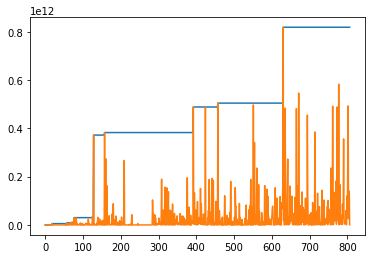

In [108]:
v = []
for i, res in enumerate(optimizer1.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
# plt.yscale('log')
plt.show()

In [110]:
df = pd.DataFrame({
    'CFV': v})
df.to_csv('CFV_Iter_8S_Dynamic1.csv')

df = pd.DataFrame({
    'CFV': vn})
df.to_csv('bestCFV_Iter_8S_Dynamic1.csv')

### Step 3 and 4:

In [111]:
optimizer2 = pickle.load( open( "config8DynsMultiplicative2.optim", "rb" ) )

In [112]:
# Best utility value generated
print(optimizer2.max)

{'target': 4749946791803.424, 'params': {'IPTG1': 0.5548156496950459, 'IPTG2': 0.5382066946638088, 'aTc1': 29.606789217538488, 'aTc2': 30.366587425843594}}


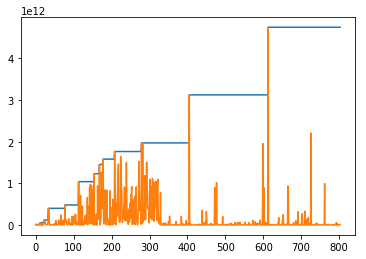

In [113]:
v = []
for i, res in enumerate(optimizer2.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
# plt.yscale('log')
plt.show()

In [114]:
df = pd.DataFrame({
    'CFV': v})
df.to_csv('CFV_Iter_8S_Dynamic2.csv')

df = pd.DataFrame({
    'CFV': vn})
df.to_csv('bestCFV_Iter_8S_Dynamic2.csv')

### Step 5 and 6:

In [115]:
optimizer3 = pickle.load( open( "config8DynsMultiplicative3.optim", "rb" ) )

In [117]:
# Best utility value generated
print(optimizer3.max)

{'target': 38269354053180.26, 'params': {'IPTG1': 0.4314653404705473, 'IPTG2': 0.41516232874849357, 'aTc1': 10.498492201681774, 'aTc2': 9.144701008074563}}


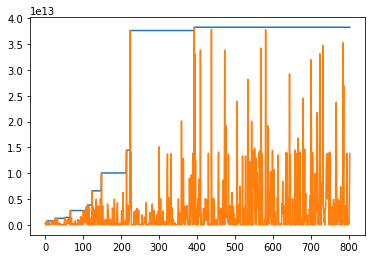

In [127]:
v = []
for i, res in enumerate(optimizer3.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
# plt.yscale('log')
plt.show()

In [128]:
df = pd.DataFrame({
    'CFV': v})
df.to_csv('CFV_Iter_8S_Dynamic3.csv')

df = pd.DataFrame({
    'CFV': vn})
df.to_csv('bestCFV_Iter_8S_Dynamic3.csv')

### Step 7 and 8:

In [116]:
optimizer4 = pickle.load( open( "config8DynsMultiplicative4.optim", "rb" ) )

In [118]:
# Best utility value generated
print(optimizer4.max)

{'target': 83019917439740.6, 'params': {'IPTG1': 0.4364848741078504, 'IPTG2': 0.45030212079531806, 'aTc1': 16.37587399256819, 'aTc2': 10.088433136032894}}


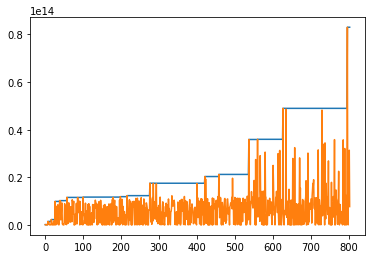

In [129]:
v = []
for i, res in enumerate(optimizer4.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
# plt.yscale('log')
plt.show()

In [130]:
df = pd.DataFrame({
    'CFV': v})
df.to_csv('CFV_Iter_8S_Dynamic4.csv')

df = pd.DataFrame({
    'CFV': vn})
df.to_csv('bestCFV_Iter_8S_Dynamic4.csv')

### Check results with plot

In [121]:

inputs = [round(0.777,2)+1e-7, int(20.01)+1e-7, round(0.755,2)+1e-7, int(22.61)+1e-7,
          round(0.555,2)+1e-7, int(29.60)+1e-7, round(0.538,2)+1e-7, int(30.36)+1e-7,
          round(0.4314,2)+1e-7, int(10.4984)+1e-7, round(0.4151,2)+1e-7, int(9.1447)+1e-7,
          round(0.4364,2)+1e-7, int(16.3758)+1e-7, round(0.4503,2)+1e-7, int(10.0884)+1e-7]

ivss = [1,1e-7,1363.193,28.510]

    
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(1440),9))]
t =  np.linspace(0,(1440),(1440)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')

RFP_M1 = solM1[:,0:len(pM1[:,1])]
GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2 = solM2[:,0:len(pM2[:,1])]
GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]


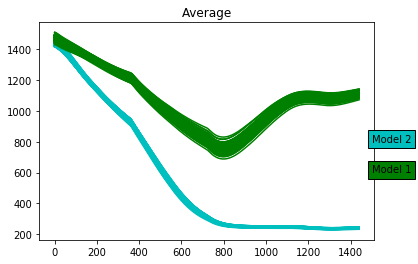

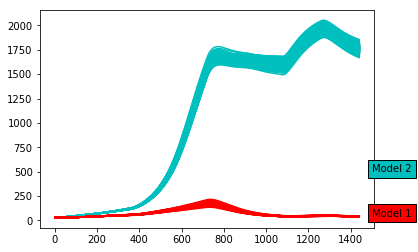

In [122]:
t = np.linspace(0,(1440),round(1440/5)+1)

plt.figure()
lines = plt.plot(t, GFP_M2, 'c')
plt.text((1500)+1, 800, "Model 2", bbox=dict(facecolor='c'))
plt.title("Average")
lines2 = plt.plot(t, GFP_M1, 'g')
plt.text((1500)+1, 600, "Model 1", bbox=dict(facecolor='g'))

plt.show()
plt.figure()
plt.plot(t, RFP_M2, 'c')

plt.text((1500)+1, 500, "Model 2", bbox=dict(facecolor='c'))
plt.text((1500)+1, 40, "Model 1", bbox=dict(facecolor='r'))
plt.plot(t, RFP_M1, 'r')
plt.show()

### Check utility decomposition results

In [123]:
# Gaussian Process Regression and Reduction

# Means and standard deviations for each time point for each species and for each model
tgp = np.linspace(0,(24*60),(24*60/5)+1)

muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
sdR3 = RFP_M2.std(axis = 1)
muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
sdG3 = GFP_M2.std(axis = 1)
muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
sdR2 = RFP_M1.std(axis = 1)
muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
sdG2 = GFP_M1.std(axis = 1)

# Gaussian Process regression
gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
gR3.findhyperparameters(noruns=15)
gR3.predict(tgp)

gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
gG3.findhyperparameters(noruns=15)
gG3.predict(tgp)

gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
gR2.findhyperparameters(noruns=15)
gR2.predict(tgp)

gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
gG2.findhyperparameters(noruns=15)
gG2.predict(tgp)



In [124]:
muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R2.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G2.predict(tref)

In [125]:
bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
u_B = (bdR+bdG)/2

In [126]:
print("The BD for RFP is: ", str(bdR))
print("The BD for GFP is: ", str(bdG))
print("The average BD is: ", str(u_B))
print("The Multiplicative BD is: ", str(bdR*bdG))

The BD for RFP is:  98356.19491561106
The BD for GFP is:  40835.21976214405
The average BD is:  69595.70733887756
The Multiplicative BD is:  4016396834.347253
